# Comparison of Regression Analysis Using Various Regressors in Scikit-learn

The regression analysis is to determine how locking in a fixed rate of COF for a TOB compared to leaving the funding cost floating at the 7-day rate based on the historical data, and to see if we can identify the driving factors if they exist, and use the factors to make statistic predictions for the differences in COF for th two funding strategies.  For this analysis, we use a fixed term of 4y for the analysis, i.e., we'll compare the COF for fixing the COF at the market SIFMA swap rate, and the average COF of the floating COF realized during a 4y time window following the COF fixing date by calculating the difference between the two COF, which is labelled as'Realized_4yPremium' in the data file.

Since the fixed COF is a known number that remains unchanged for the remaining 4 years, the realized premium will be determined by the 7day SIFMA rate resets to be realized over the 4y following the COF fixing date.  Basic macroeconomics suggusts that the resets will depend on macroeconomic data such as GDP, inflation and inflation expectations, etc. To build an econometric regression model, or a forecast model, the model inputs can only use data up to the COF fixed date, any data after that should not be used as model inputs.

One may be tempted to use the macroeconomic data such as those mentioned above as the independent variables.  However, there is a serious problem that would limit this approach to be of any use.  The first problem is that 7-day SIFMA resets should be correlated to the macro data on the reset date, our dependent variable, the Realized4yPremium is for the 4y time window following the COF fixing date, hence the the macroeconomic data to be used for the model should be the expected data for the same time window, which do not exist.  Even the data exist, we know that the correlation bwteen the short rate reset and contemperaneous macroeconomic data is weak at the best.  

Our hypothesis is that the futures market for the short term interest rates should reflect market participants' expection of the macroeconomic conditions in the future.  The expectation is quantitatively measured in the market rates of the term swaps.  Therefore we believe that the term swap rate quoted on the COF fixing date can be used as the independent variables, or features in ML terminology, for the model.  Fortunately liquid markets exist for both the taxable and tax-exempt swap market, we use the swap rates traded in the tax-exempt market as the model inputs as TOBs are for tax-exempt bonds.

Historical SIFMA swap rates of maturities of 7days,1y, 2y,3y,4y, and 5y since 2007 are collected for this analysis.


In [1]:
#Import Libraries

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



In [2]:
#Load Data
#Data consists of historical SIFMA swap rates of maturities of 7days,1y, 2y,3y,4y, and 5y.
Data = pd.read_csv('C:/Users/tingl/OneDrive/Documents/Python/Muni/Data4Realized4yPremium.csv')

In [3]:
#data summary info
Data.info()
#Data.count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   D4yPrior_Date       591 non-null    object 
 1   Realized_4yPremium  591 non-null    float64
 2   T4yPrior_SIFMA      591 non-null    float64
 3   T4yPrior_1ySwap     591 non-null    float64
 4   T4yPrior_2ySwap     591 non-null    float64
 5   T4yPrior_3ySwap     591 non-null    float64
 6   T4yPrior_4ySwap     591 non-null    float64
 7   T4yPrior_5ySwap     591 non-null    float64
dtypes: float64(7), object(1)
memory usage: 37.1+ KB


In [4]:
Data.head()

,D4yPrior_Date,Realized_4yPremium,T4yPrior_SIFMA,T4yPrior_1ySwap,T4yPrior_2ySwap,T4yPrior_3ySwap,T4yPrior_4ySwap,T4yPrior_5ySwap
0,4/25/2018,1.27,1.75,1.665,1.862,1.983,2.06,2.12
1,4/18/2018,1.21,1.81,1.644,1.832,1.939,2.00,2.05
2,4/11/2018,1.13,1.72,1.589,1.772,1.869,1.93,1.98
3,4/4/2018,1.15,1.60,1.577,1.772,1.877,1.95,2.00
4,3/28/2018,1.11,1.58,1.556,1.747,1.847,1.92,1.98


In [5]:
Data.tail()

,D4yPrior_Date,Realized_4yPremium,T4yPrior_SIFMA,T4yPrior_1ySwap,T4yPrior_2ySwap,T4yPrior_3ySwap,T4yPrior_4ySwap,T4yPrior_5ySwap
586,1/31/2007,1.99,3.50,3.602,3.562,3.557,3.56,3.61
587,1/24/2007,1.97,3.61,3.599,3.540,3.524,3.55,3.59
588,1/17/2007,1.94,3.62,3.591,3.535,3.522,3.54,3.59
589,1/10/2007,1.85,3.63,3.548,3.461,3.437,3.47,3.51
590,1/3/2007,1.83,3.45,3.524,3.466,3.412,3.45,3.48


In [156]:
#check the dependent variable Y
y=Data['Realized_4yPremium']
y.describe()

count    591.000000
mean       0.900931
std        0.822446
min       -0.550000
25%        0.330000
50%        0.600000
75%        1.590000
max        2.750000
Name: Realized_4yPremium, dtype: float64

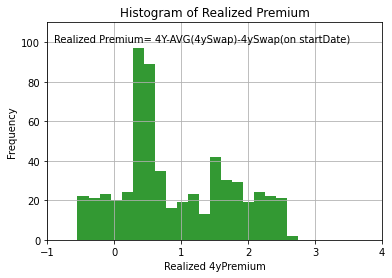

In [101]:
#show histogram of y
n, bins, patches = plt.hist(y, 20, density=0, facecolor='g', alpha=0.8)
plt.xlabel('Realized 4yPremium')
plt.ylabel('Frequency')
plt.title('Histogram of Realized Premium')
plt.text(-0.9, 100, r'Realized Premium= 4Y-AVG(4ySwap)-4ySwap(on startDate)')
plt.axis([-1, 4, 0, 110])
plt.grid(True)
plt.show()

In [108]:
#n and bins returns values for counts and bin borders
bins

array([-0.55 , -0.385, -0.22 , -0.055,  0.11 ,  0.275,  0.44 ,  0.605,
        0.77 ,  0.935,  1.1  ,  1.265,  1.43 ,  1.595,  1.76 ,  1.925,
        2.09 ,  2.255,  2.42 ,  2.585,  2.75 ])

'Realized 4y Premium'

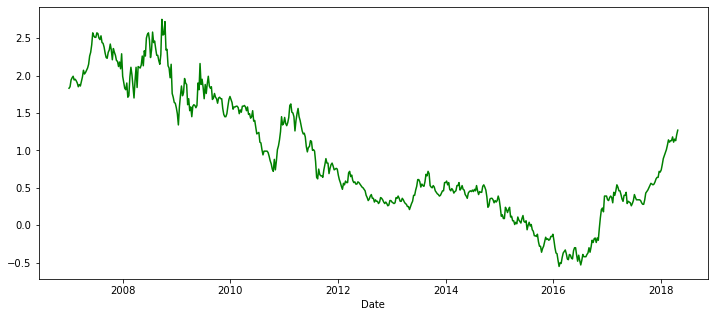

In [158]:
plt.figure(figsize=(12,5))
DT=pd.to_datetime(Data['D4yPrior_Date'])
type(DT)
ax=plt.plot(DT, y, color='g')
plt.xlabel('Date')
plt.ylabel

In [201]:
#Before defining y and x variables, we can check the correlation matrix first.  We need to drop the Date col first
xy=Data.drop(['D4yPrior_Date'], axis=1)
xy.corr()


,Realized_4yPremium,T4yPrior_SIFMA,T4yPrior_1ySwap,T4yPrior_2ySwap,T4yPrior_3ySwap,T4yPrior_4ySwap,T4yPrior_5ySwap
Realized_4yPremium,1.000000,0.669999,0.726648,0.781776,0.838441,0.882804,0.915235
T4yPrior_SIFMA,0.669999,1.000000,0.954004,0.931701,0.900182,0.865537,0.828883
T4yPrior_1ySwap,0.726648,0.954004,1.000000,0.990231,0.963548,0.931086,0.894675
T4yPrior_2ySwap,0.781776,0.931701,0.990231,1.000000,0.990296,0.968402,0.938875
T4yPrior_3ySwap,0.838441,0.900182,0.963548,0.990296,1.000000,0.992941,0.974956
T4yPrior_4ySwap,0.882804,0.865537,0.931086,0.968402,0.992941,1.000000,0.994179
T4yPrior_5ySwap,0.915235,0.828883,0.894675,0.938875,0.974956,0.994179,1.000000



We see that the Realized_4yPremium has high correlations to all of the swap rates, so it looks promissing that our hypothesis will be statistically validated.  Because of the the swap rates are very correlated amongst themselves, it's likely that we'll not need all of the swap rates as the independent variables.  Based on the correlation matrix, T4yPrior_4ySwap and T4yPrior_5ySwap have the highest correlation coefficients. We'll first run regression analysis using all input variables as the independent factors, then using only T4yPrior_4ySwap and T4yPrior_5ySwap as the independent factors as they are mostly correlcted to the dependent variable.


In [305]:
#Define x, and y, note that we need to use numpy array for the x and y to be used as input for sklearn regressors
y=Data['Realized_4yPremium'].values
#dropping the Date col and y col
x=Data.drop(['Realized_4yPremium','D4yPrior_Date'], axis=1).values
#check what x is
print(x)

[[1.75  1.665 1.862 1.983 2.06  2.12 ]
 [1.81  1.644 1.832 1.939 2.    2.05 ]
 [1.72  1.589 1.772 1.869 1.93  1.98 ]
 ...
 [3.62  3.591 3.535 3.522 3.54  3.59 ]
 [3.63  3.548 3.461 3.437 3.47  3.51 ]
 [3.45  3.524 3.466 3.412 3.45  3.48 ]]


In [306]:
#Split dataset into training set and test set, with 25% data randomly selected as the test data
x_train,  x_test, y_train, y_test =train_test_split(x,y,test_size=0.25, random_state=1)

In [307]:
#train linear regression model on the training data
LR=LinearRegression()
LR.fit(x_train,y_train)
print("R_Square:", LR.score(x_train,y_train))

R_Square: 0.9068694874789982


In [308]:
#prediction using test data
y_pred=LR.predict(x_test)

In [309]:
#Calc r-square for the test data
print("R_Square:", r2_score(y_pred, y_test))

R_Square: 0.9012004874948562


In [310]:
#Cacl mean-squared-error for the test data
print("MSE:", mean_squared_error(y_pred, y_test))

MSE: 0.059670867580460404


In [311]:
# Run regression analysis using only the 4y and 5y swap rates as the independent variable
x=Data.drop(['Realized_4yPremium','D4yPrior_Date','T4yPrior_SIFMA','T4yPrior_1ySwap','T4yPrior_2ySwap','T4yPrior_3ySwap'], axis=1).values
y=Data['Realized_4yPremium'].values
#Split dataset into training set and test set, with 25% data randomly selected as the test data
x_train,  x_test, y_train, y_test =train_test_split(x,y,test_size=0.25, random_state=1)

In [312]:
#train linear regression model on the training data
LR=LinearRegression()
LR.fit(x_train,y_train)
print("R_Square:", LR.score(x_train,y_train))

R_Square: 0.9010580365240635


In [313]:
#prediction using test data
y_pred=LR.predict(x_test)
#Calc r-square for the test data
print("R_Square:", r2_score(y_pred, y_test))

R_Square: 0.8965966880946858


In [315]:
#Cacl mean-squared-error for the test data
print("MSE:", mean_squared_error(y_pred, y_test))

MSE: 0.06176518979213677


In [314]:
#print out regression coefficients
print("Coefficients: \n", LR.coef_)
print("Intercept: \n", LR.intercept_)

Coefficients: 
 [-2.20941306  3.18214232]
Intercept: 
 -1.147405456903586


Text(0.5, 1.0, 'y_test and y_pred vs. 4y swap')

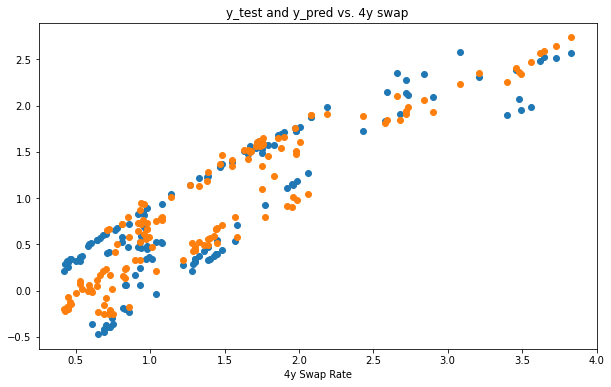

In [284]:
#plot regression 
x1=x_test[:,0]
x2=x_test[:,1]

plt.figure(figsize=(10,6))
plt.scatter(x1, y_test)
plt.scatter(x1, y_pred)
#note that x2 is not fixed for the y vs. x1 plot
plt.xlabel("4y Swap Rate")
plt.title("y_test and y_pred vs. 4y swap")
#plt.ylabel("Predicted")


we see that results of using all swaps rates for the regression analysis are only marginally better than using only the 4y and 5y swap rates.  Therefore we can use the results of using only the 4y and 5y swap rates for simplicity.

Given the regression results, we can conclude that we can predict, with ~90% confidence based on the 4y and 5y swap rates on the fixing date, the premium of fixing the OCF over the floating to be realized for the 4 years following the fixing date.

The regression analysis above can also be carried out in MSExcel, even though the data setup will not be as easy as in Python.  In the following, we'll do more analysis not available in Excel. We'll show how to use various ML models available in sklearn, a Python library.


Before getting into using nonlinear models, we'll experiment with PCA to show how PCA works.  PCA is a commonly used method for dimension reduction.  With PCA, we use the so-called Principal Component, which is a linear combination of the original factors/features.  The principal components are constructed to be orthogonal to each other, i.e. the correlation matrix for the principal components only have non-zero values along the diagnal of the matrix.  We'll run linear regression using the principal components as the independent variables.  

In [316]:
#import PCA from library
from sklearn.decomposition import PCA

In [323]:
x4pca=Data.drop(['Realized_4yPremium','D4yPrior_Date','T4yPrior_SIFMA'], axis=1).values
y=Data['Realized_4yPremium'].values
pca=PCA(n_components=2)
#we choose the first 2 Principal components so that we'll have the same number of independent variables for linear regression.
pca.fit(x4pca)
xpca=pca.transform(x4pca)
xpca.shape

(591, 2)

In [324]:
xpca

array([[ 1.56084946, -0.18269575],
       [ 1.46262077, -0.22832726],
       [ 1.3181659 , -0.24943937],
       ...,
       [ 5.1909862 , -0.3475778 ],
       [ 5.03498285, -0.37972055],
       [ 4.99363474, -0.39304672]])

In [325]:
#to see the data in a better format
xdf=pd.DataFrame(xpca, columns=["PC1","PC2"])
xdf.head()

,PC1,PC2
0,1.560849,-0.182696
1,1.462621,-0.228327
2,1.318166,-0.249439
3,1.332798,-0.221610
4,1.276534,-0.226637


In [326]:
#Split dataset into training set and test set
xpca_train,  xpca_test, y_train, y_test =train_test_split(xpca,y,test_size=0.25, random_state=1)

In [329]:
#train linear regression model on training data
PCA_LR=LinearRegression()
PCA_LR.fit(xpca_train,y_train)
print("R_Square:", PCA_LR.score(xpca_train,y_train))

R_Square: 0.8672257729005755


In [330]:
#Cacl mean-squared-error for the test data
print("MSE:", mean_squared_error(y_pred, y_test))

MSE: 0.06176518979213677


In [332]:
#PCA contribution to variance
pca.explained_variance_ratio_

array([0.97096734, 0.0276632 ])

we'll now use the following nonlinear regressiors: Decision Tree, Random Forrest, SVM and Neural Network

In [225]:
#import Decision Tree
from sklearn.tree import DecisionTreeRegressor
#create a model
DT_data =DecisionTreeRegressor().fit(x_train,y_train)


In [226]:
print(DT_data.score(x_train,y_train))

0.9998278368029373


In [229]:
DT_ypred=DT_data.predict(x_train)
print(r2_score(DT_ypred, y_train))

0.9998278071576671


In [230]:
DT_ytest=DT_data.predict(x_test)
print(r2_score(DT_ytest, y_test))

0.9071774405205761


In [39]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=10,random_state=12)

In [40]:

#Split dataset into training set and test set
x_train,  x_test, y_train, y_test =train_test_split(x,y,test_size=0.3, random_state=1)

rf_model=rf.fit(x_train,y_train)


In [41]:
rf_model.score(x_train,y_train)

0.9909112335707475

In [42]:
y_rfpred=rf_model.predict(x_test)
r2_score(y_rfpred, y_test)

0.9420339282121755

In [43]:
from sklearn.svm import SVR

In [44]:
SVM_regression=SVR()
SVM_regression.fit(x_train,y_train)

SVR()

In [45]:
SVM_regression.score(x_train,y_train)

0.9348425638424869

In [46]:
y_svmtrain=SVM_regression.predict(x_train)

r2_score(y_svmtrain, y_train)


0.9313591139847857

In [47]:
y_svmpred=SVM_regression.predict(x_test)
r2_score(y_svmpred, y_test)

0.943040238733662

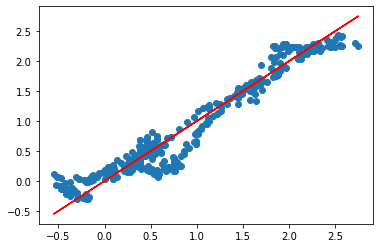

In [48]:
#plot training data
plt.scatter(y_train, y_svmtrain)
plt.plot(y_train, y_train, "red")

In [49]:
#plot test data

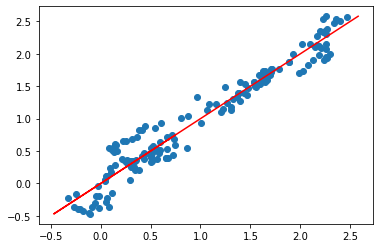

In [50]:
#sns.scatterplot(y_test,y_svmpred)
plt.scatter(y_svmpred, y_test)
plt.plot(y_test, y_test, "red")

In [51]:
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [52]:
NN=MLPRegressor(hidden_layer_sizes=(150,),max_iter=1000, activation="relu",random_state=12)


In [53]:
NN.fit(x_train,y_train)


MLPRegressor(hidden_layer_sizes=(150,), max_iter=1000, random_state=12)

In [54]:
y_nnpred=NN.predict(x_test)

In [55]:
r2_score(y_nnpred, y_test)

0.9172634629796868

In [56]:
y_nntrain=NN.predict(x_train)

In [57]:
r2_score(y_nntrain, y_train)

0.9142214246375718

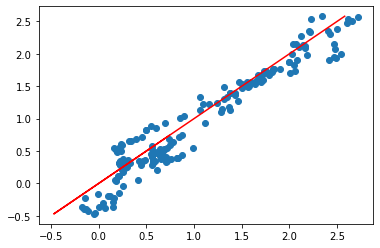

In [58]:
#plot test data 
plt.scatter(y_nnpred, y_test)
plt.plot(y_test, y_test, "red")